In [1]:
from mpl_toolkits.mplot3d import Axes3D
from google.colab import drive
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import cv2

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/Dataset.zip'

In [5]:
import zipfile
import os

# Define the file path and extraction directory
zip_file_path = '/content/drive/My Drive/Dataset.zip'
extract_to = '/content/extracted_files'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Files extracted to:", extract_to)

Files extracted to: /content/extracted_files


In [6]:
DATASET_PATH = "extracted_files/Dataset/"
print(os.listdir(DATASET_PATH))

df = pd.read_csv(DATASET_PATH + "Cleaned_Apparel2.csv", nrows=24798, on_bad_lines='skip')
df['image'] = df.apply(lambda row: str(row['id_x']) + ".jpg", axis=1)

df = df.reset_index(drop=True)
df.head(10)

['Cleaned_Apparel2.csv', 'images']


,Unnamed: 0,id_x,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Emotion_Category,image
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Rainy,2011.0,Casual,Turtle Check Men Navy Blue Shirt,Neutral,15970.jpg
1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Sunny,2012.0,Casual,Peter England Men Party Blue Jeans,Contentment,39386.jpg
2,3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Rainy,2011.0,Casual,Manchester United Men Solid Black Track Pants,Anger,21379.jpg
3,4,53759,Men,Apparel,Topwear,Tshirts,Grey,Sunny,2012.0,Casual,Puma Men Grey T-shirt,Sadness,53759.jpg
4,5,1855,Men,Apparel,Topwear,Tshirts,Grey,Sunny,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,Sadness,1855.jpg
5,6,30805,Men,Apparel,Topwear,Shirts,Green,Sunny,2012.0,Ethnic,Fabindia Men Striped Green Shirt,Contentment,30805.jpg
6,7,26960,Women,Apparel,Topwear,Shirts,Purple,Sunny,2012.0,Casual,Jealous 21 Women Purple Shirt,Sadness,26960.jpg
7,10,9204,Men,Footwear,Shoes,Casual Shoes,Black,Sunny,2011.0,Casual,Puma Men Future Cat Remix SF Black Casual Shoes,Anger,9204.jpg
8,12,18653,Men,Footwear,Flip Flops,Flip Flops,Black,Rainy,2011.0,Casual,Fila Men Cush Flex Black Slippers,Anger,18653.jpg
9,14,46885,Men,Footwear,Flip Flops,Flip Flops,Navy Blue,Rainy,2012.0,Casual,Ben 10 Boys Navy Blue Slippers,Neutral,46885.jpg


In [7]:
# Function to get the full path of the image
def img_path(img):
    return os.path.join(DATASET_PATH, "images", img)

# Function to load original image without resizing
def load_image_no_resize(img):
    img_full_path = img_path(img)
    img = cv2.imread(img_full_path)
    if img is not None:
        return img
    else:
        print(f"Warning: Unable to load image {img}")
        return None

# Function to load image and resize
def load_image_resized(img, resized_fac=0.5):
    img_full_path = img_path(img)
    img = cv2.imread(img_full_path)
    if img is not None:
        h, w, _ = img.shape
        resized = cv2.resize(img, (int(w * resized_fac), int(h * resized_fac)), interpolation=cv2.INTER_LINEAR)
        return resized
    else:
        print(f"Warning: Unable to load image {img}")
        return None

# Function to display multiple images
def plot_figures(figures, nrows=1, ncols=1, figsize=(12, 8), dpi=150):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    for i, (title, img) in enumerate(figures.items()):
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].set_title(title, fontsize=10)
            axes[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
            axes[i].axis('off')
    plt.tight_layout()
    plt.show()

Original sizes of first 5 images:
15970.jpg: (80, 60, 3)
39386.jpg: (80, 60, 3)
21379.jpg: (80, 60, 3)
53759.jpg: (80, 60, 3)
1855.jpg: (80, 60, 3)


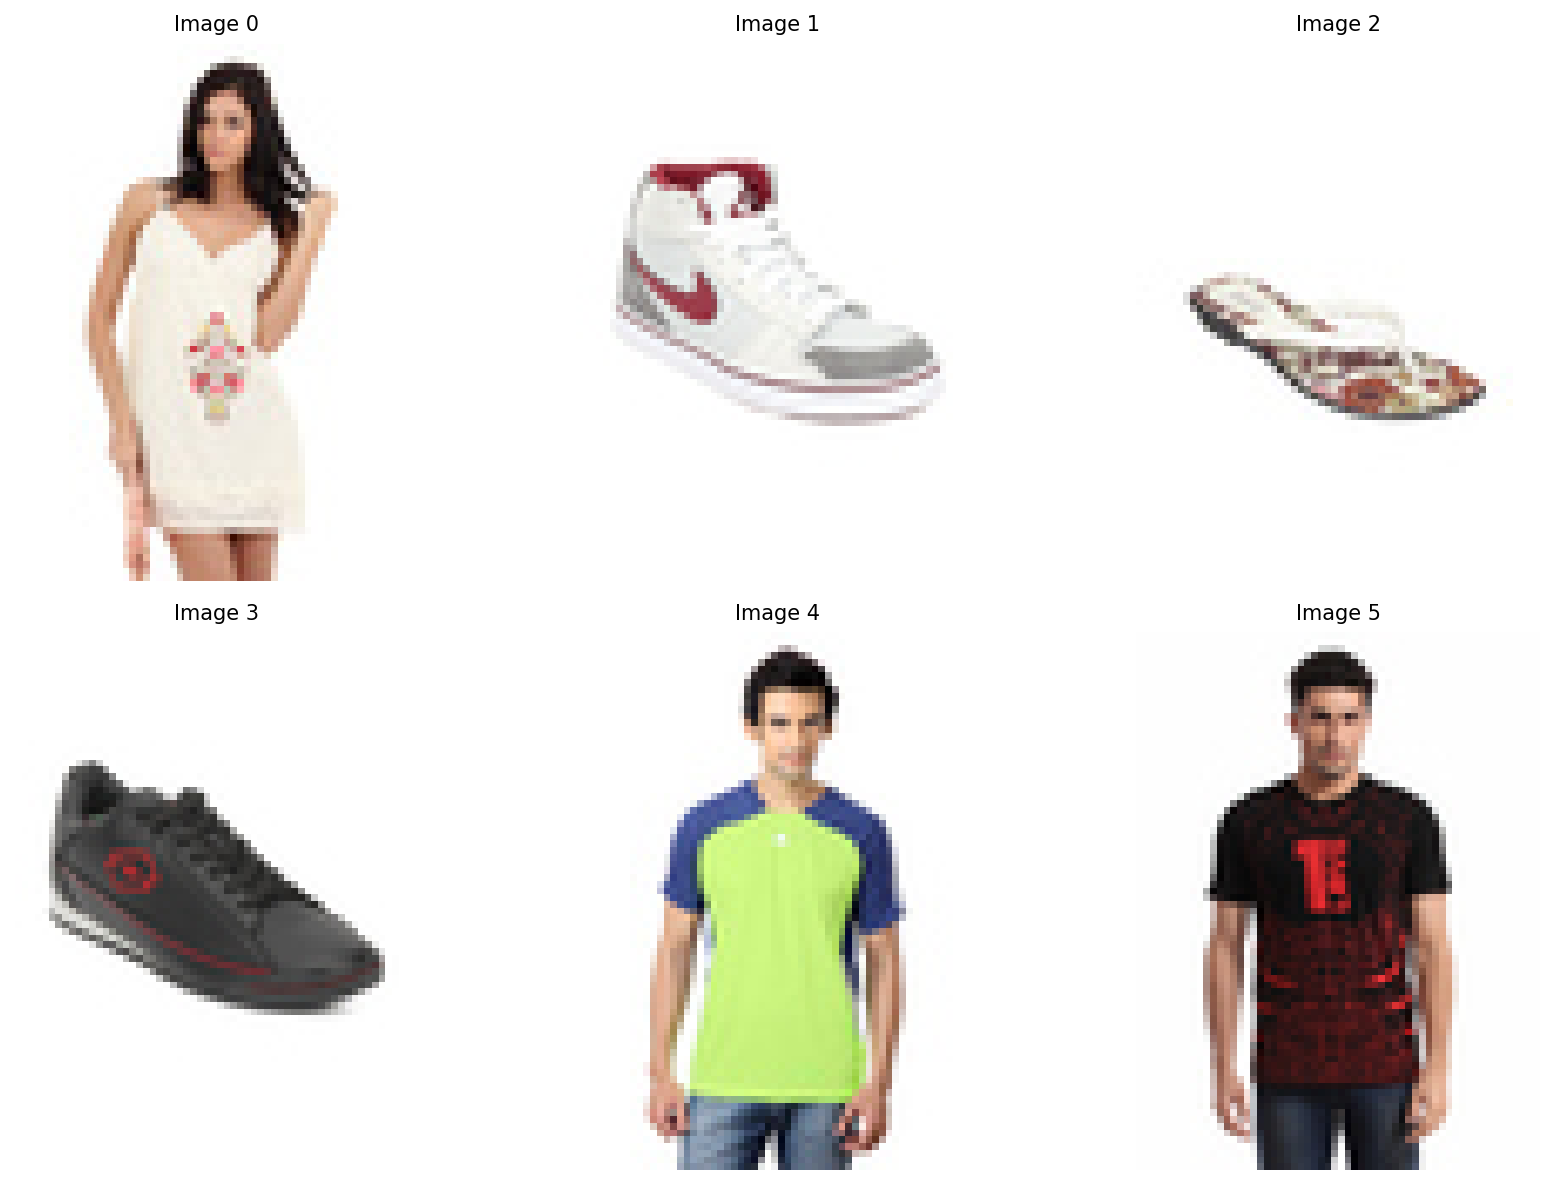

In [8]:
# Check original image size
print("Original sizes of first 5 images:")
for i in range(5):
    img_name = df.iloc[i]['image']
    img = load_image_no_resize(img_name)
    if img is not None:
        print(f"{img_name}: {img.shape}")  # (height, width, channels)
    else:
        print(f"{img_name}: Image not loaded")

# Display original image without resizing
figures_no_resize = {}

sample_df = df.sample(6).reset_index(drop=True)

for i, row in sample_df.iterrows():
    img = load_image_no_resize(row['image'])
    if img is not None:
        figures_no_resize[f"Image {i}"] = img

plot_figures(figures_no_resize, nrows=2, ncols=3, figsize=(12, 8), dpi=150)

<Axes: ylabel='articleType'>

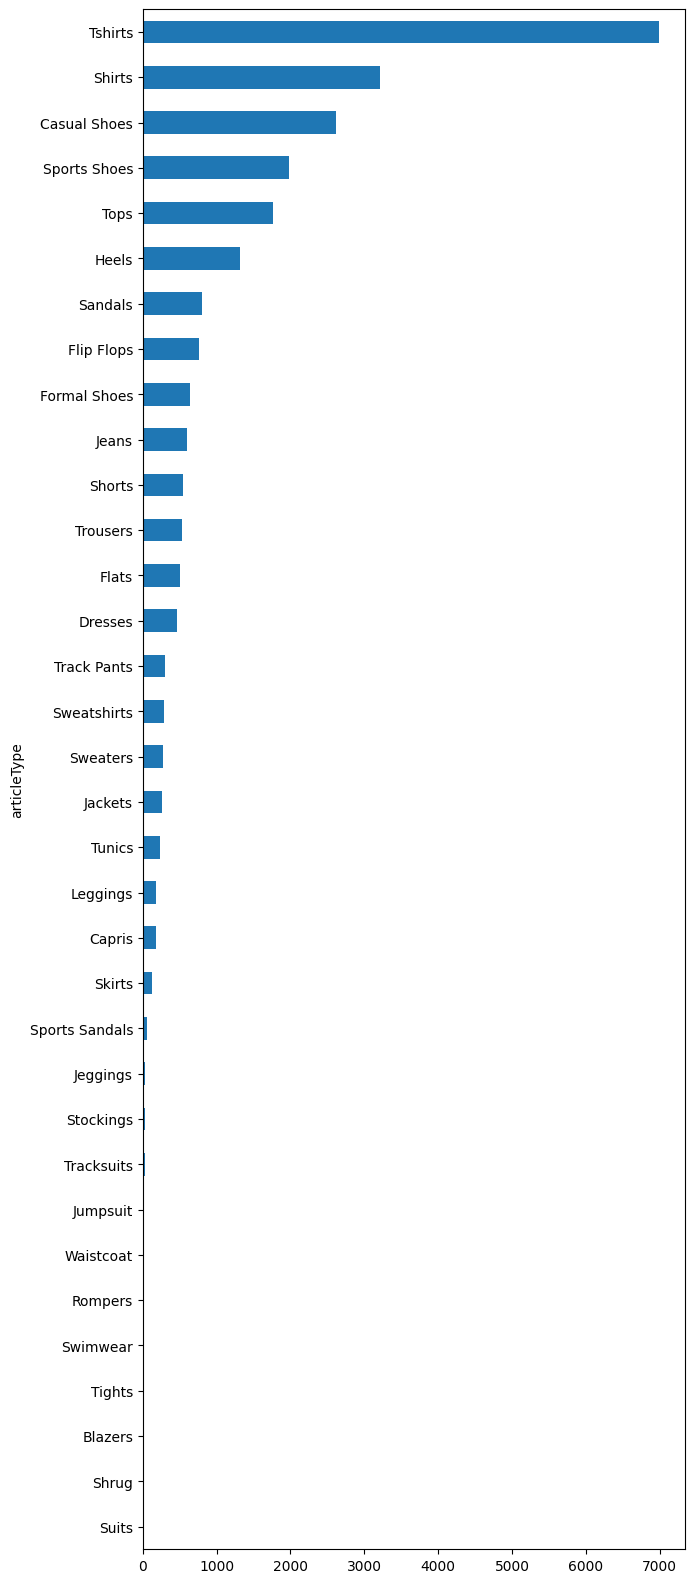

In [9]:
plt.figure(figsize=(7,20))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Sequential

# Initialize ResNet50 model
img_width, img_height, _ = 224, 224, 3
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

# Add GlobalMaxPooling2D layer to get embedding
model = Sequential([
    base_model,
    GlobalMaxPooling2D()
])

# Show model structure
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
def get_embedding(model, img_name):
    try:
        img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return model.predict(x).reshape(-1)

    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        return np.nan

In [13]:
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras import Sequential

# Filter valid data
df_filtered = df.dropna(subset=['image']).reset_index(drop=True)
print(f"Number of rows after filtering: {df_filtered.shape[0]}")

# Function to get image path
def img_path(img_name):
    return f"{DATASET_PATH}/images/{img_name}"

# Function to calculate embedding for an image
def get_embedding(model, img_name):
    try:
        img = image.load_img(img_path(img_name), target_size=(224, 224))  # Resize ảnh
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)  # Add batch dimension
        x = preprocess_input(x)  # Preprocessing
        return model.predict(x).reshape(-1)  # Return the embedding vector

    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {img_name}: {e}")
        return np.nan

# Initialize ResNet50 model

img_width, img_height = 224, 224
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalMaxPooling2D()
])

# Show model structure
model.summary()

Number of rows after filtering: 24797


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 2048)                │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# Batch embedding calculation function

from IPython.display import clear_output

# Example: Clear output after each batch
def compute_embeddings_in_batch(model, images, batch_size=32):
    embeddings = []
    total_batches = (len(images) + batch_size - 1) // batch_size  # Total number of batches

    for i in range(0, len(images), batch_size):
        batch_images = images[i:i + batch_size]
        batch_embeddings = []

        for img in batch_images:
            embedding = get_embedding(model, img)
            batch_embeddings.append(embedding)

        embeddings.extend(batch_embeddings)

        # Clear output after each batch
        clear_output(wait=True)
        print(f"Processed batch {i // batch_size + 1}/{total_batches}")

    return embeddings

# Calculate embedding
print("Start embedding calculation...")

embeddings = compute_embeddings_in_batch(model, df_filtered['image'].tolist(), batch_size=32)

# Convert embedding to DataFrame, handling NaN values
df_embs = pd.DataFrame([emb for emb in embeddings if not np.isnan(emb).any()]) # Filter out embeddings with NaN values

# Remove rows with NaN values (this line is now redundant but kept for clarity)
df_clean = df_embs.dropna()

# Check size after removing NaN
print(f"Number of rows before removing NaNs: {df_embs.shape[0]}")

print(f"Number of rows after removing NaN: {df_clean.shape[0]}")

# Show the first few rows
df_clean.head(10)

Processed batch 775/775
Number of rows before removing NaNs: 24792
Number of rows after removing NaN: 24792


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.228653,6.758031,0.000000,1.157923,4.044771,4.190840,7.823343,8.598853,1.214278,0.000000,...,1.759050,5.455353,2.264873,22.648228,0.318423,0.000000,9.307659,2.485376,2.589488,18.344494
1,2.160766,13.004471,0.092264,6.950650,5.372192,0.000000,15.559411,2.178860,0.848539,0.146076,...,2.459627,8.469259,5.472922,8.990246,3.187692,0.256664,7.267747,0.000000,6.571844,17.669731
2,0.000000,5.336301,1.670134,11.411581,1.258598,0.000000,12.816571,7.772430,0.845030,2.947619,...,29.042683,1.647553,0.176533,0.000000,6.040608,1.806891,10.376255,0.000000,16.299793,16.499523
3,2.663746,15.295513,0.032792,2.476947,6.908768,2.586331,9.054915,7.316330,0.000000,0.000000,...,2.014328,6.502707,3.596585,19.685736,6.044678,0.000000,8.757938,2.212007,4.258549,17.862133
4,1.196888,9.465169,3.959119,3.310766,4.172623,0.000000,7.413352,2.370900,2.777586,6.932272,...,3.938444,2.859155,2.247991,17.592136,0.253539,3.850347,6.854544,1.996476,8.032393,16.529812
5,2.692019,12.962125,6.995639,2.550272,0.212964,0.000000,0.579042,8.016428,0.000000,0.000000,...,8.074385,2.841673,0.000000,17.579628,0.000000,0.815755,7.742965,6.793867,3.896430,6.004035
6,0.000000,7.076756,0.000000,3.865230,2.024600,0.895758,2.083068,1.910335,3.880332,0.835527,...,4.237893,4.720810,4.666629,14.129210,5.321120,0.000000,12.770954,4.054196,2.739104,4.012745
7,1.499455,1.153028,5.223221,0.000000,3.877710,10.550033,4.378710,4.948905,2.223275,0.000000,...,0.498734,5.976805,2.694166,0.000000,2.715871,7.275645,0.919224,0.650789,6.954916,1.359664
8,0.000000,0.839951,1.972961,0.390812,5.365160,1.791893,7.219367,1.242238,1.688268,0.000000,...,0.000000,8.277502,0.000000,0.000000,11.000808,6.638534,13.038217,3.999138,2.902048,7.825822
9,0.089349,0.000000,6.243013,2.441898,0.470464,6.234199,0.985619,7.854414,3.892302,0.000000,...,14.232155,3.802810,1.326976,4.938066,3.582548,0.284768,1.239550,2.517563,10.421501,0.000000


In [20]:
# Check that `df_filtered` and `df_clean` have matching line numbers
if len(df_clean) != len(df_filtered):
    # Adjust so that the line numbers match
    min_len = min(len(df_clean), len(df_filtered))
    df_clean = df_clean.iloc[:min_len].reset_index(drop=True)
    df_filtered = df_filtered.iloc[:min_len].reset_index(drop=True)

df_combined = pd.concat([df_filtered, df_clean], axis=1)
df_combined.head()

,Unnamed: 0,id_x,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Rainy,2011.0,Casual,...,1.759050,5.455353,2.264873,22.648228,0.318423,0.000000,9.307659,2.485376,2.589488,18.344494
1,1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Sunny,2012.0,Casual,...,2.459627,8.469259,5.472922,8.990246,3.187692,0.256664,7.267747,0.000000,6.571844,17.669731
2,3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Rainy,2011.0,Casual,...,29.042683,1.647553,0.176533,0.000000,6.040608,1.806891,10.376255,0.000000,16.299793,16.499523
3,4,53759,Men,Apparel,Topwear,Tshirts,Grey,Sunny,2012.0,Casual,...,2.014328,6.502707,3.596585,19.685736,6.044678,0.000000,8.757938,2.212007,4.258549,17.862133
4,5,1855,Men,Apparel,Topwear,Tshirts,Grey,Sunny,2011.0,Casual,...,3.938444,2.859155,2.247991,17.592136,0.253539,3.850347,6.854544,1.996476,8.032393,16.529812


In [23]:
df_combined.to_csv("/content/drive/My Drive/extracted_data.csv", index=False)